In [1]:
#!pip install keras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import warnings
from skimage.io import imread
from PIL import Image
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [29]:
IMG_SIZE = 48
DATA_DIR = '/content/drive/MyDrive/5243/Project3/images'
EMOTIONS = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']
csv_path = '/content/drive/MyDrive/5243/Project3/emotions.csv'
emotions_df = pd.read_csv(csv_path)

In [30]:
emotions_df['set_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

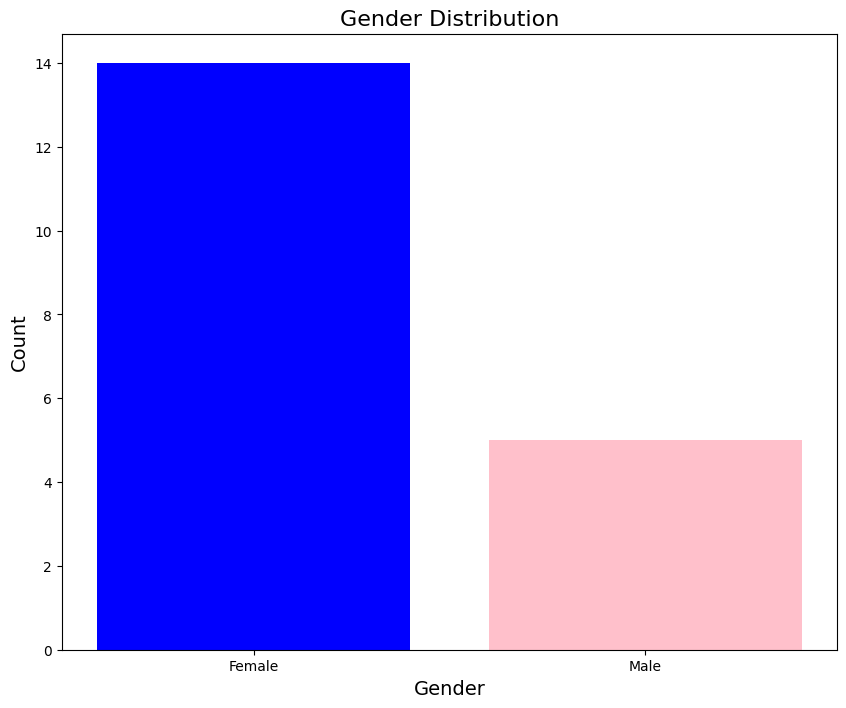

In [5]:
# Gender distribution
plt.figure(figsize=(10, 8))
gender_counts = emotions_df['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'pink'])
plt.title('Gender Distribution', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

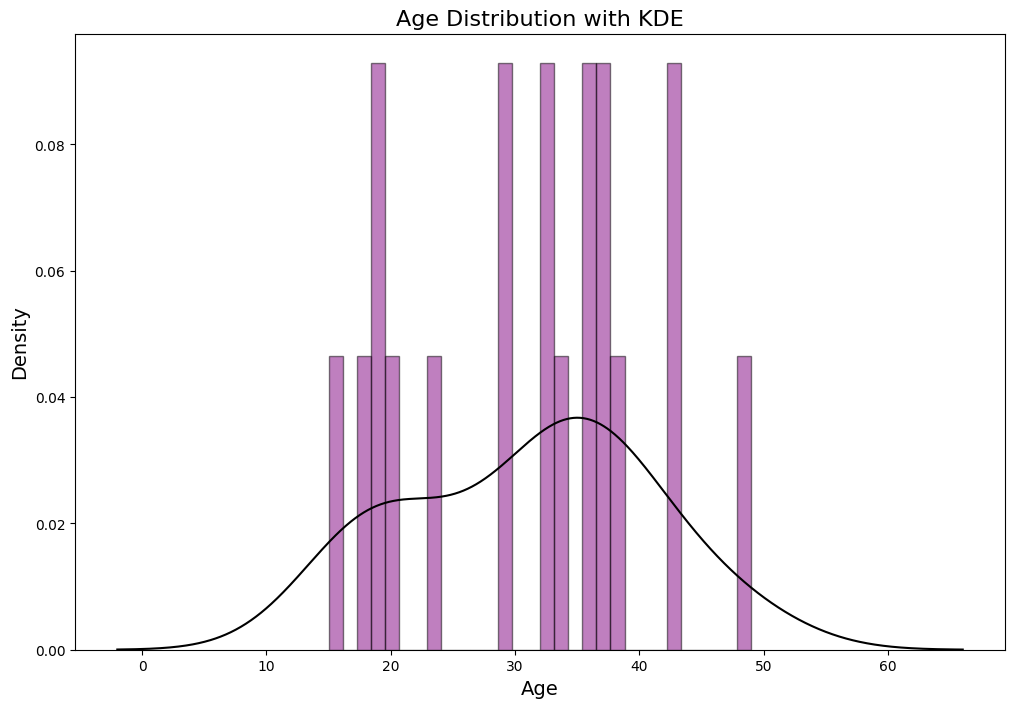

In [6]:
# Age distribution
plt.figure(figsize=(12, 8))
emotions_df['age'].plot(kind='hist', bins=30, density=True, alpha=0.5, color='purple', edgecolor='black')
emotions_df['age'].plot(kind='kde', color='black')
plt.title('Age Distribution with KDE', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

In [7]:
emotions_df['age'].mean()

31.105263157894736

<Figure size 1000x800 with 0 Axes>

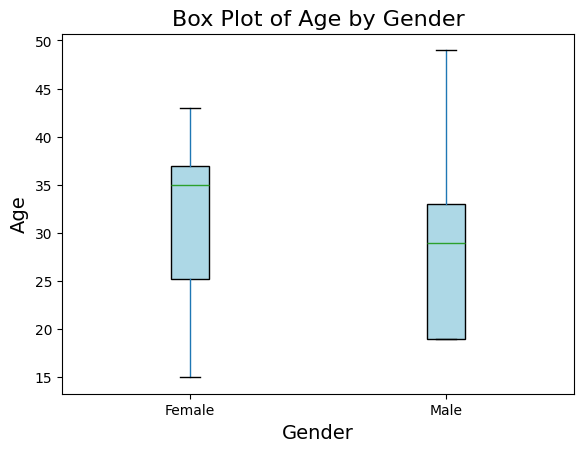

In [8]:
# Box plot of age by gender
plt.figure(figsize=(10, 8))
emotions_df.boxplot(column='age', by='gender', grid=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Box Plot of Age by Gender', fontsize=16)
plt.suptitle('')
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.xticks([1, 2], ['Female', 'Male'])
plt.show()

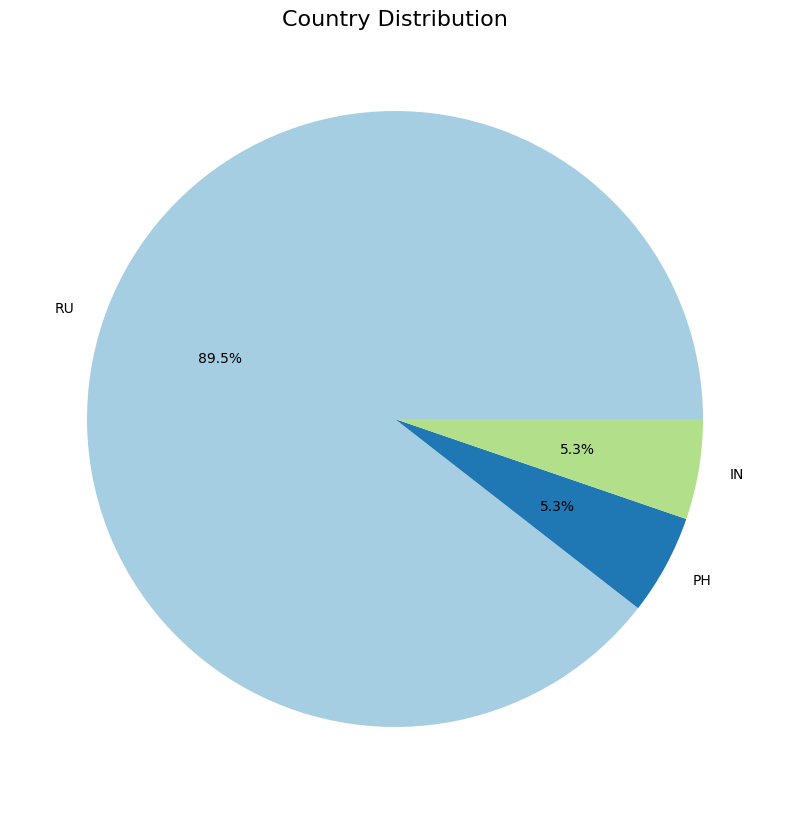

In [9]:
# Country distribution
country_counts = emotions_df['country'].value_counts()
plt.figure(figsize=(12, 10))
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired(np.arange(len(country_counts))))
plt.title('Country Distribution', fontsize=16)
plt.show()

# CNN

In [31]:
# Encode the gender column
label_encoder = LabelEncoder()
emotions_df['gender'] = label_encoder.fit_transform(emotions_df['gender'])

In [32]:
# Load and preprocess images
def load_data():
    images = []
    labels = []

    for emotion_label, emotion in enumerate(EMOTIONS):
        emotion_dir = os.path.join(DATA_DIR, str(emotion_label))
        if os.path.isdir(emotion_dir):
            for img_file in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_file)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                images.append(img_resized)
                labels.append(emotion_label)
        else:
            print(f"Directory not found for emotion {emotion}: {emotion_dir}")

    return np.array(images), np.array(labels)

images, labels = load_data()

In [33]:
# Normalize images
images = images / 255.0

# Encode labels to categorical
labels_categorical = to_categorical(labels, num_classes=len(EMOTIONS))

In [34]:
print("Distribution of emotions:")
print(pd.Series(labels).value_counts())

Distribution of emotions:
0    8
1    8
2    8
3    8
4    8
5    8
6    8
7    8
Name: count, dtype: int64


In [35]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

In [36]:
# Reshape for the model
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [37]:
# Training
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(EMOTIONS), activation='softmax')  # Ensure the correct number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.1201 - loss: 2.0891 - val_accuracy: 0.0769 - val_loss: 2.0759
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1436 - loss: 2.0493 - val_accuracy: 0.1538 - val_loss: 2.0738
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2349 - loss: 2.0225 - val_accuracy: 0.1538 - val_loss: 2.0275
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2167 - loss: 1.9863 - val_accuracy: 0.3846 - val_loss: 1.9836
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1436 - loss: 2.0434 - val_accuracy: 0.3077 - val_loss: 1.9448
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2714 - loss: 1.9238 - val_accuracy: 0.5385 - val_loss: 1.8993
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3499 - loss: 1.8749 - val_accuracy: 0.5385 - val_loss: 1.8008
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4726 - loss: 1.7991 - val_accuracy: 0.6154 - val_loss: 1.6872
Epoch 9/20
2/

In [38]:
# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Overall Test Accuracy: {test_accuracy}")

1/1 - 0s - 20ms/step - accuracy: 0.8462 - loss: 0.2672
Overall Test Accuracy: 0.8461538553237915


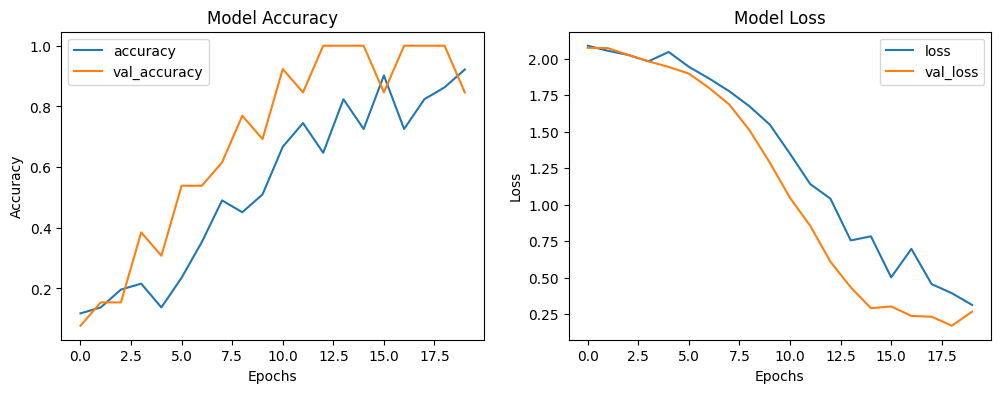

In [39]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


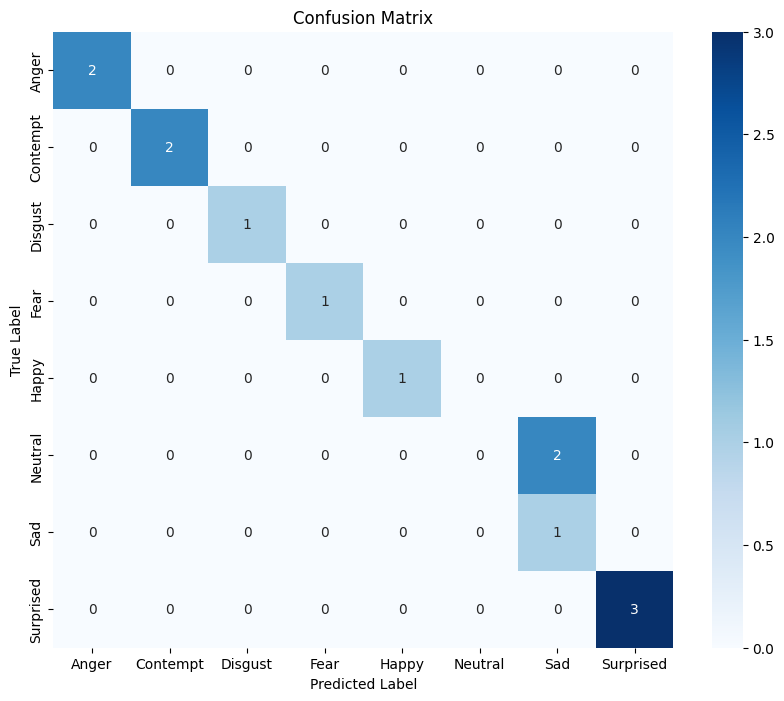

              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00         2
    Contempt       1.00      1.00      1.00         2
     Disgust       1.00      1.00      1.00         1
        Fear       1.00      1.00      1.00         1
       Happy       1.00      1.00      1.00         1
     Neutral       0.00      0.00      0.00         2
         Sad       0.33      1.00      0.50         1
   Surprised       1.00      1.00      1.00         3

    accuracy                           0.85        13
   macro avg       0.79      0.88      0.81        13
weighted avg       0.79      0.85      0.81        13



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:
# Model Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_df = pd.DataFrame(cm, index=EMOTIONS, columns=EMOTIONS)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=EMOTIONS)
print(report)

In [2]:
import numpy as np

# Confusion matrix values (replace with your actual matrix)
cm = np.array([[2, 0, 0, 0, 0, 0, 0, 0],
               [0, 2, 0, 0, 0, 0, 0, 0],
               [0, 0, 1, 0, 0, 0, 0, 0],
               [0, 0, 0, 1, 0, 0, 0, 0],
               [0, 0, 0, 0, 1, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 2, 0],
               [0, 0, 0, 0, 0, 0, 1, 0],
               [0, 0, 0, 0, 0, 0, 0, 3]])

# Extract True Positives (TP) - diagonal
TP = np.diag(cm)

# Calculate False Positives (FP) - sum of columns minus TP
FP = np.sum(cm, axis=0) - TP

# Calculate PPV (Precision)
PPV = TP / (TP + FP)
PPV = np.nan_to_num(PPV)  # Handle division by zero

# Display results
emotions = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprised']
for i, emotion in enumerate(emotions):
    print(f"PPV for {emotion}: {PPV[i]:.2f}")

PPV for Anger: 1.00
PPV for Contempt: 1.00
PPV for Disgust: 1.00
PPV for Fear: 1.00
PPV for Happy: 1.00
PPV for Neutral: 0.00
PPV for Sad: 0.33
PPV for Surprised: 1.00


<ipython-input-2-f2f9c401711e>:20: RuntimeWarning: invalid value encountered in divide
  PPV = TP / (TP + FP)


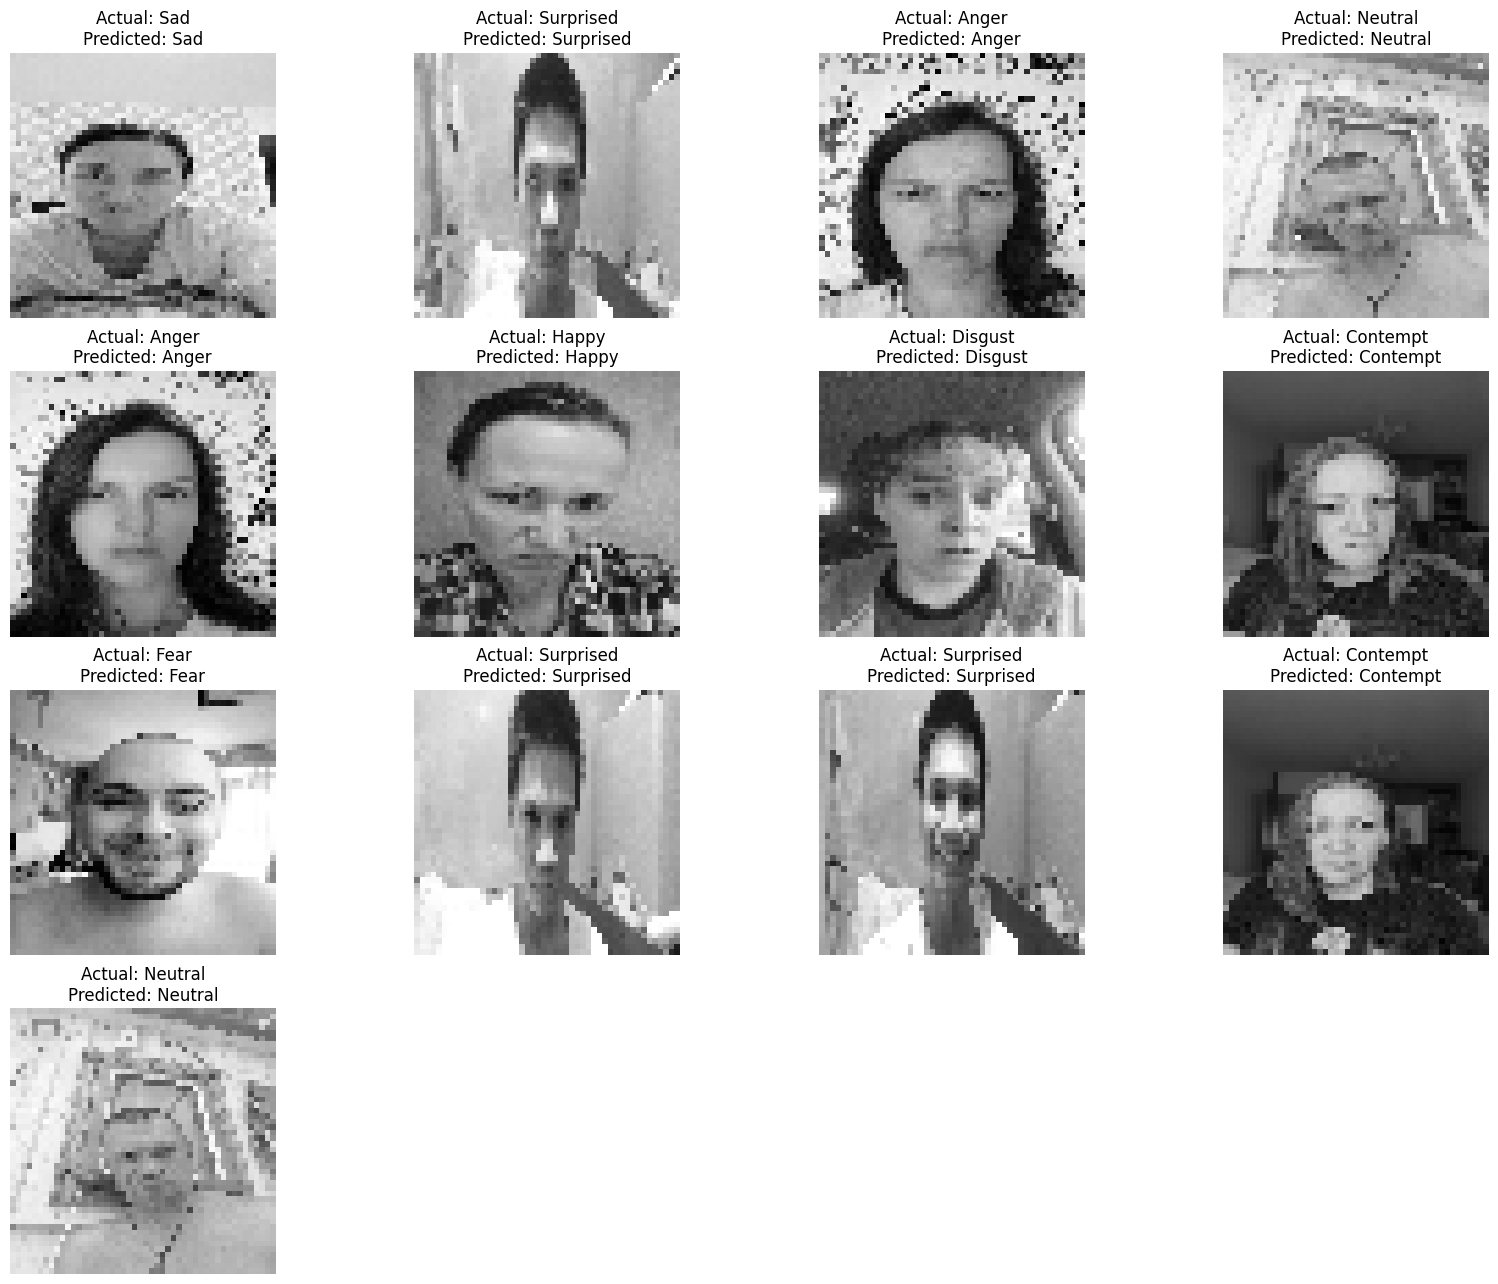

In [20]:
# Images with predicted and actual labels
num_images = min(20, len(X_test))
plt.figure(figsize=(20, 20))
for i in range(num_images):
    plt.subplot(5, 4, i + 1)
    img = (X_test[i] * 255).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Actual: {EMOTIONS[y_true[i]]}\nPredicted: {EMOTIONS[y_pred_classes[i]]}")
    plt.axis('off')
plt.show()

## Model Examination

Saliency Maps

In [21]:
import tensorflow as tf

def generate_saliency_map(model, image, class_index):
    # Convert image to a tensor and add batch dimension
    image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor)
        loss = predictions[0, class_index]

    gradients = tape.gradient(loss, image_tensor)
    gradients = tf.reduce_max(gradients, axis=-1)[0]

    # Normalize the gradients for visualization
    gradients = tf.maximum(gradients, 0)  # Keep positive gradients
    saliency_map = gradients / tf.reduce_max(gradients)
    return saliency_map.numpy()

def visualize_saliency(image, saliency_map, title):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Saliency Map")
    plt.imshow(saliency_map, cmap='hot')
    plt.colorbar()
    plt.axis("off")

    plt.suptitle(title)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


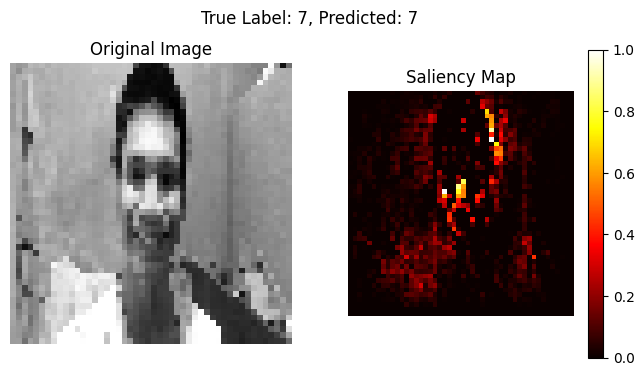

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


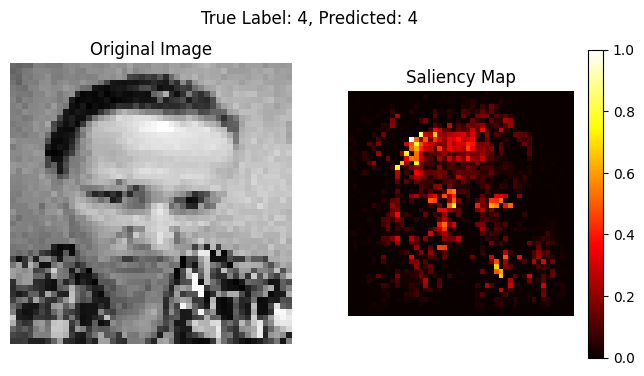

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


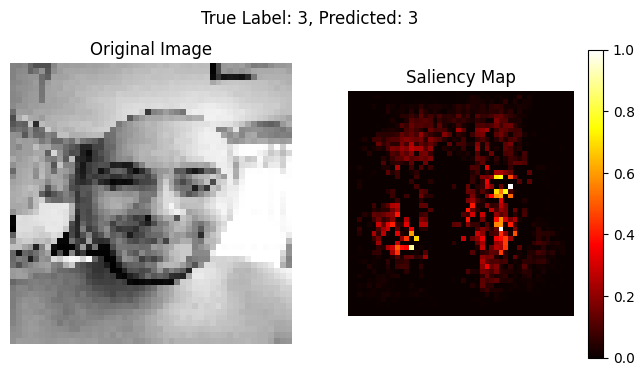

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


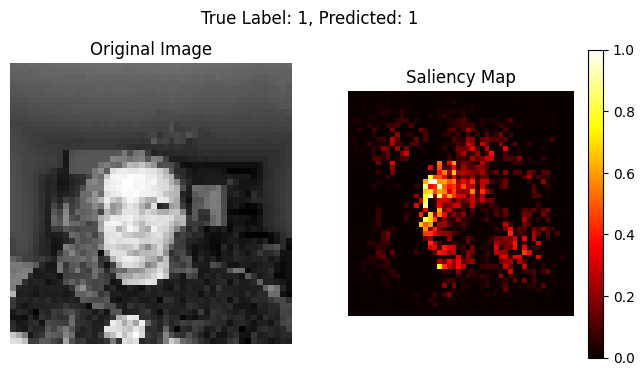

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


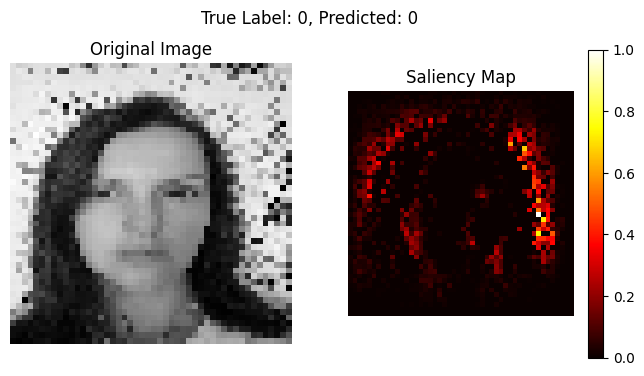

In [22]:
# Randomly select a few test images and generate saliency maps
num_samples = 5
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

for idx in random_indices:
    image = X_test[idx]
    label = np.argmax(y_test[idx])  # True label
    predicted_class = np.argmax(model.predict(np.expand_dims(image, axis=0)))

    saliency_map = generate_saliency_map(model, image, predicted_class)

    title = f"True Label: {label}, Predicted: {predicted_class}"
    visualize_saliency(image, saliency_map, title)

Sensitivity Analysis

In [23]:
def occlusion_sensitivity(model, image, patch_size=20, stride=10):
    height, width = image.shape[:2]
    sensitivity_map = np.zeros((height, width))

    original_prediction = model.predict(np.expand_dims(image, axis=0))
    original_class = np.argmax(original_prediction)

    for i in range(0, height - patch_size, stride):
        for j in range(0, width - patch_size, stride):
            occluded_image = image.copy()
            occluded_image[i:i + patch_size, j:j + patch_size] = 0  # Black out a patch

            occluded_prediction = model.predict(np.expand_dims(occluded_image, axis=0))
            sensitivity_map[i:i + patch_size, j:j + patch_size] = original_prediction[0, original_class] - \
                                                                 occluded_prediction[0, original_class]

    return sensitivity_map

def visualize_sensitivity_map(image, sensitivity_map):
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title("Sensitivity Map")
    plt.imshow(sensitivity_map, cmap='hot')
    plt.colorbar()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Visualizing Sensitivity Map for Test Sample Index: 10, True Label: 7


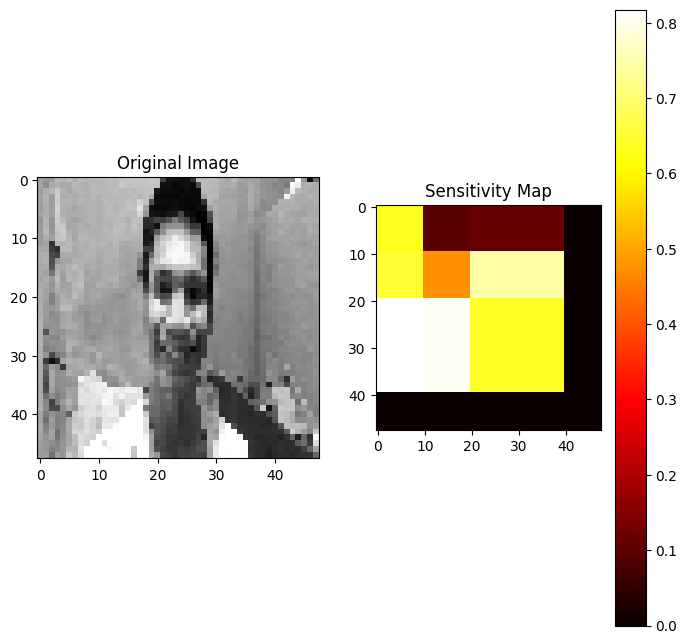

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Visualizing Sensitivity Map for Test Sample Index: 2, True Label: 0


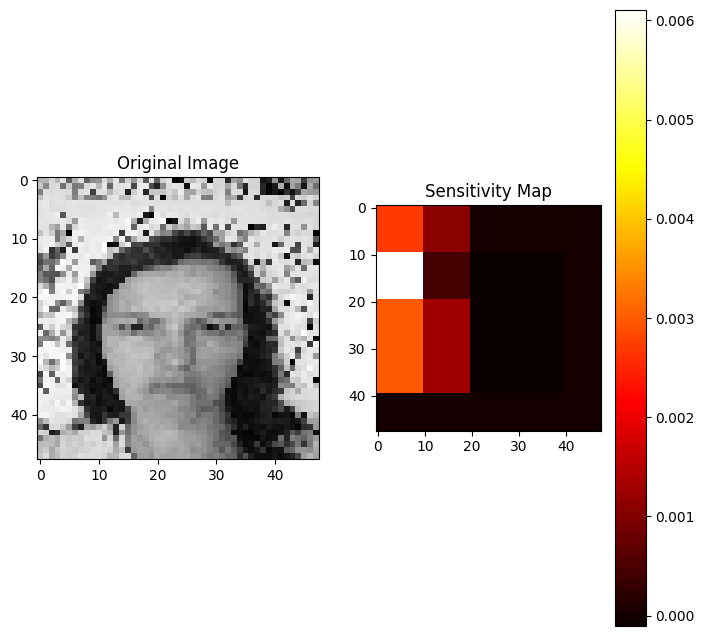

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Visualizing Sensitivity Map for Test Sample Index: 4, True Label: 0


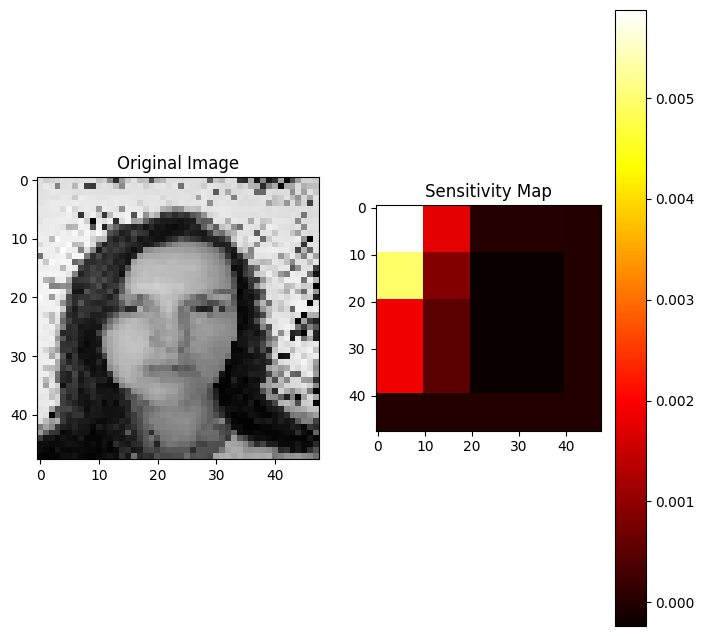

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Visualizing Sensitivity Map for Test Sample Index: 7, True Label: 1


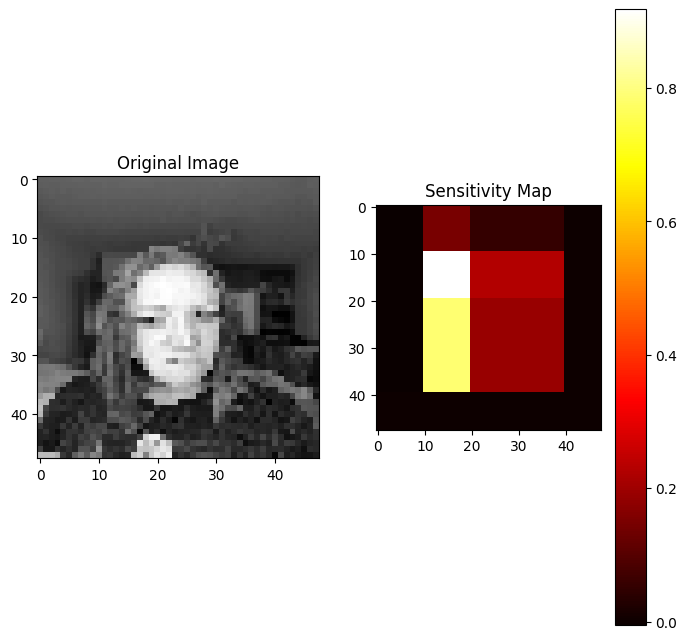

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Visualizing Sensitivity Map for Test Sample Index: 12, True Label: 5


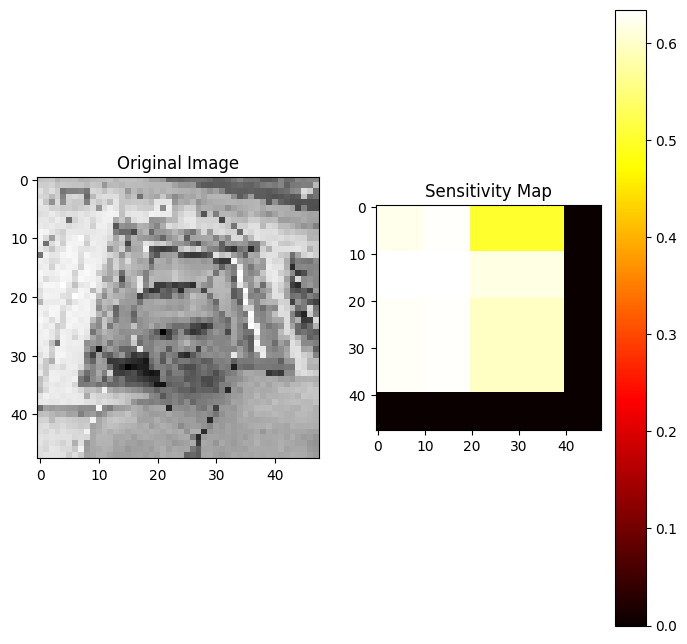

In [24]:
import random

num_samples = 5

# Randomly select 5 indices from the test set
random_indices = random.sample(range(len(X_test)), num_samples)

for idx in random_indices:
    image = X_test[idx]
    label = np.argmax(y_test[idx])

    sensitivity_map = occlusion_sensitivity(model, image, patch_size=20, stride=10)

    print(f"Visualizing Sensitivity Map for Test Sample Index: {idx}, True Label: {label}")
    visualize_sensitivity_map(image, sensitivity_map)

## Group by countires

In [25]:
image_metadata = []

for folder in os.listdir(DATA_DIR):
    folder_path = os.path.join(DATA_DIR, folder)
    if os.path.isdir(folder_path):
        set_id = int(folder)
        for img_file in os.listdir(folder_path):
            image_metadata.append({
                'set_id': set_id,
                'img_path': os.path.join(folder_path, img_file)
            })

image_df = pd.DataFrame(image_metadata)

# Merge with emotions_df to associate images with metadata
merged_df = pd.merge(image_df, emotions_df, on='set_id')

# Replace 'IN' and 'PH' with 'OTHER'
merged_df['Country_Group'] = merged_df['country'].replace({'IN': 'OTHER', 'PH': 'OTHER'})

In [26]:
# Split into train and test sets, stratified by Country_Group
train_data, test_data = train_test_split(merged_df, test_size=0.2, stratify=merged_df['Country_Group'], random_state=42)

In [27]:
IMG_SIZE = 48

def load_images(data_subset):
    images = []
    labels = []
    for _, row in data_subset.iterrows():
        img_path = row['img_path']
        img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img_array is not None:
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            images.append(img_resized)
            labels.append(row['set_id'])  # Replace with the appropriate label logic if needed
        else:
            print(f"Image not found: {img_path}")
    return np.array(images), np.array(labels)

# Load train and test sets
X_train, y_train = load_images(train_data)
X_test, y_test = load_images(test_data)

# Normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape for CNN input
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [28]:
# CNN model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(train_data['set_id'].unique()), activation='softmax')  # Use the correct number of classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train
model = create_model()
model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Overall Test Accuracy: {test_accuracy}")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - accuracy: 0.0443 - loss: 2.9385 - val_accuracy: 0.1200 - val_loss: 3.0325
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1120 - loss: 2.8093 - val_accuracy: 0.2000 - val_loss: 3.0658
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4023 - loss: 2.6643 - val_accuracy: 0.1200 - val_loss: 2.9810
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4154 - loss: 2.4072 - val_accuracy: 0.4400 - val_loss: 2.8100
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6771 - loss: 2.1709 - val_accuracy: 0.4000 - val_loss: 2.5286
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6003 - loss: 1.8646 - val_accuracy: 0.6000 - val_loss: 2.2348
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7773 - loss: 1.4596 - val_accuracy: 0.6000 - val_loss: 2.0103
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7878 - loss: 1.1569 - val_accuracy: 0.7600 - val_loss: 1.6464
Epoch 9/10

In [29]:
from sklearn.metrics import classification_report, accuracy_score

# Add predictions to the test dataset
y_pred = model.predict(X_test).argmax(axis=1)
test_data['y_pred'] = y_pred
test_data['y_true'] = y_test

# Evaluate performance by Country_Group
for group in test_data['Country_Group'].unique():
    group_data = test_data[test_data['Country_Group'] == group]
    accuracy = accuracy_score(group_data['y_true'], group_data['y_pred'])
    report = classification_report(group_data['y_true'], group_data['y_pred'])

    print(f"Performance for Country_Group {group}:")
    print(f"Accuracy: {accuracy}")
    print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
Performance for Country_Group RU:
Accuracy: 0.6785714285714286
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         0
           3       0.17      0.50      0.25         2
           4       1.00      0.75      0.86         4
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           8       0.00      0.00      0.00         2
           9       0.50      1.00      0.67         2
          10       0.00      0.00      0.00         0
          12       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       0.00      0.00      0.00         5
          16       1.00      1.00      1.00         3
          17       1.00      1.00      1.00         2
          18       1.00      1.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

<ipython-input-30-30f9a8457ea4>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_accuracies = test_data.groupby('Country_Group').apply(lambda df: accuracy_score(df['y_true'], df['y_pred']))


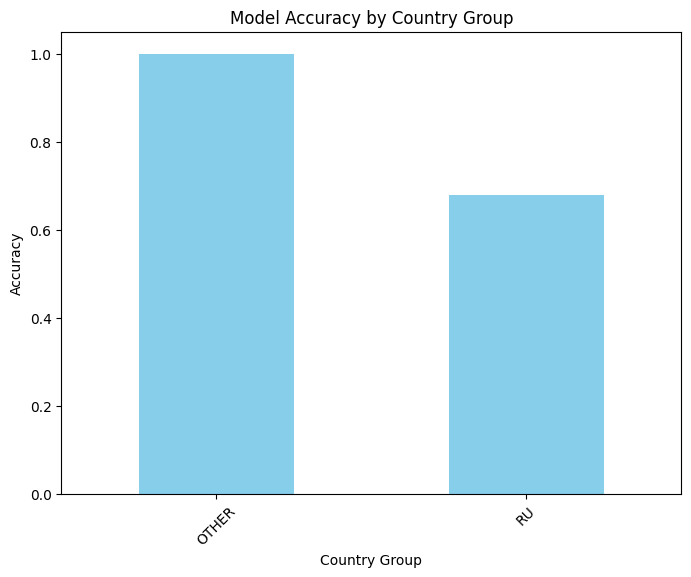

In [30]:
# Calculate accuracy by Country_Group
group_accuracies = test_data.groupby('Country_Group').apply(lambda df: accuracy_score(df['y_true'], df['y_pred']))

# Bar plot
plt.figure(figsize=(8, 6))
group_accuracies.plot(kind='bar', color='skyblue')
plt.title('Model Accuracy by Country Group')
plt.ylabel('Accuracy')
plt.xlabel('Country Group')
plt.xticks(rotation=45)
plt.show()

## Group by Ages

In [31]:
# Add age group based on the 'age' column
# Average age is 31
merged_df['Age_Group'] = merged_df['age'].apply(lambda x: 'Under_31' if x < 31 else 'Beyond_31')

In [32]:
# Split into train and test sets, stratified by Age_Group
train_data, test_data = train_test_split(merged_df, test_size=0.2, stratify=merged_df['Age_Group'], random_state=42)

In [33]:
# Load train and test sets
X_train, y_train = load_images(train_data)
X_test, y_test = load_images(test_data)

# Normalize and reshape as before
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [34]:
# Train
model = create_model()
model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Overall Test Accuracy: {test_accuracy}")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.0182 - loss: 2.9807 - val_accuracy: 0.1600 - val_loss: 2.9386
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1654 - loss: 2.8264 - val_accuracy: 0.0800 - val_loss: 2.9040
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3568 - loss: 2.6730 - val_accuracy: 0.0400 - val_loss: 2.8571
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3711 - loss: 2.4289 - val_accuracy: 0.3200 - val_loss: 2.7337
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6602 - loss: 2.1463 - val_accuracy: 0.4000 - val_loss: 2.4430
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6615 - loss: 1.7243 - val_accuracy: 0.6000 - val_loss: 2.0513
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8177 - loss: 1.4048 - val_accuracy: 0.6000 - val_loss: 1.6308
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8346 - loss: 0.9600 - val_accuracy: 0.6800 - val_loss: 1.2266
Epoch 9/10

In [35]:
# Add predictions to the test dataset
y_pred = model.predict(X_test).argmax(axis=1)
test_data['y_pred'] = y_pred
test_data['y_true'] = y_test

# Evaluate performance by Age_Group
for group in test_data['Age_Group'].unique():
    group_data = test_data[test_data['Age_Group'] == group]
    accuracy = accuracy_score(group_data['y_true'], group_data['y_pred'])
    report = classification_report(group_data['y_true'], group_data['y_pred'])

    print(f"Performance for Age_Group {group}:")
    print(f"Accuracy: {accuracy}")
    print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Performance for Age_Group Beyond_31:
Accuracy: 0.9444444444444444
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      0.50      0.67         2
           6       0.67      1.00      0.80         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         3

    accuracy                           0.94        18
   macro avg       0.97      0.95      0.95        18
weighted avg       0.96      0.94      0.94        18

Performance for Age_Group Under_31:
Accuracy: 1.0
              precision    recall  f1-score   support

           3       1.00      1.

<ipython-input-36-fa7bdb575048>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_accuracies = test_data.groupby('Age_Group').apply(lambda df: accuracy_score(df['y_true'], df['y_pred']))


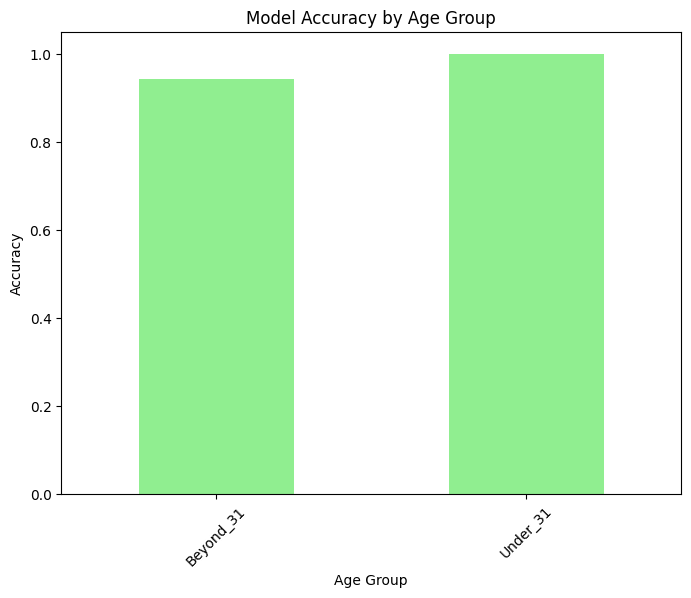

In [36]:
# Calculate accuracy by Age_Group
group_accuracies = test_data.groupby('Age_Group').apply(lambda df: accuracy_score(df['y_true'], df['y_pred']))

# Bar plot
plt.figure(figsize=(8, 6))
group_accuracies.plot(kind='bar', color='lightgreen')
plt.title('Model Accuracy by Age Group')
plt.ylabel('Accuracy')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.show()

## Group by Gender

In [37]:
gender_groups = merged_df['gender'].unique()

In [38]:
train_data, test_data = train_test_split(merged_df, test_size=0.2, stratify=merged_df['gender'], random_state=42)

In [39]:
# Load images function remains the same as before
X_train, y_train = load_images(train_data)
X_test, y_test = load_images(test_data)

# Normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape images for CNN input
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [40]:
# Train the CNN model
model = create_model()
model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Evaluate performance on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Overall Test Accuracy: {test_accuracy}")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.0312 - loss: 2.9698 - val_accuracy: 0.0000e+00 - val_loss: 2.9608
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1146 - loss: 2.8642 - val_accuracy: 0.0800 - val_loss: 2.9020
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3008 - loss: 2.7280 - val_accuracy: 0.0800 - val_loss: 2.8126
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4701 - loss: 2.5195 - val_accuracy: 0.2000 - val_loss: 2.7596
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5404 - loss: 2.2784 - val_accuracy: 0.3600 - val_loss: 2.5134
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6810 - loss: 1.9427 - val_accuracy: 0.6000 - val_loss: 2.0337
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8047 - loss: 1.5134 - val_accuracy: 0.4800 - val_loss: 1.7107
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8854 - loss: 1.0471 - val_accuracy: 0.8800 - val_loss: 1.1054
Epoch 

In [41]:
from sklearn.metrics import classification_report, accuracy_score

# Add predictions to the test dataset
y_pred = model.predict(X_test).argmax(axis=1)
test_data['y_pred'] = y_pred
test_data['y_true'] = y_test

# Evaluate performance by Gender_Group
for group in test_data['gender'].unique():
    group_data = test_data[test_data['gender'] == group]
    accuracy = accuracy_score(group_data['y_true'], group_data['y_pred'])
    report = classification_report(group_data['y_true'], group_data['y_pred'])

    print(f"Performance for Gender_Group {group}:")
    print(f"Accuracy: {accuracy}")
    print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Performance for Gender_Group 0:
Accuracy: 0.9130434782608695
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         1
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          17       1.00      1.00      1.00         2
          18       0.00      0.00      0.00         0

    accuracy                           0.91        23
   macro avg       0.93      0.86 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-42-38400983dd71>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_accuracies = test_data.groupby('gender').apply(lambda df: accuracy_score(df['y_true'], df['y_pred']))


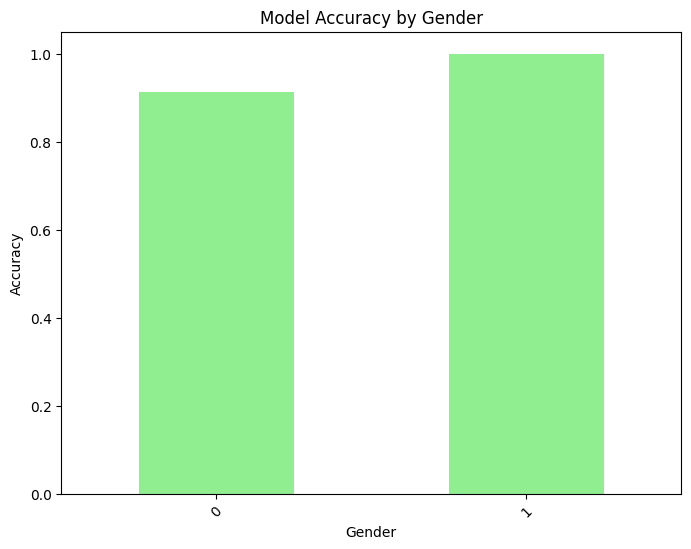

In [42]:
# Calculate accuracy by Gender_Group
group_accuracies = test_data.groupby('gender').apply(lambda df: accuracy_score(df['y_true'], df['y_pred']))

# Bar plot
plt.figure(figsize=(8, 6))
group_accuracies.plot(kind='bar', color='lightgreen')
plt.title('Model Accuracy by Gender')
plt.ylabel('Accuracy')
plt.xlabel('Gender')
plt.xticks(rotation=45)
plt.show()

# ResNet

In [43]:
# Define constants
DATA_DIR = '/content/drive/MyDrive/5243/Project3/images'

def create_image_dataframe(data_dir, emotions_df):
    image_data = []

    for _, row in emotions_df.iterrows():
        set_id = row['set_id']
        gender = row['gender']
        age = row['age']
        country = row['country']

        folder_path = os.path.join(data_dir, str(set_id))
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    image_data.append({
                        'img_path': os.path.join(folder_path, img_file),
                        'set_id': set_id,
                        'gender': gender,
                        'age': age,
                        'country': country
                    })

    return pd.DataFrame(image_data)

image_df = create_image_dataframe(DATA_DIR, emotions_df)
print(f"Number of images: {len(image_df)}")
print(image_df.head())

Number of images: 152
                                            img_path  set_id  gender  age  \
0  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   
1  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   
2  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   
3  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   
4  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   

  country  
0      RU  
1      RU  
2      RU  
3      RU  
4      RU  


In [44]:
# Extract the emotion from the image path
def extract_emotion(path):
    # Extract the filename from the path and remove the extension
    filename = os.path.basename(path)
    emotion = filename.replace(os.path.splitext(filename)[1], '')  # Remove the file extension
    return emotion

# Apply the function to the img_path column to create the 'emotion' column
image_df['emotion'] = image_df['img_path'].apply(extract_emotion)

print(image_df.head())

                                            img_path  set_id  gender  age  \
0  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   
1  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   
2  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   
3  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   
4  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   

  country   emotion  
0      RU     Anger  
1      RU  Contempt  
2      RU   Disgust  
3      RU      Fear  
4      RU     Happy  


In [45]:
# Encode the emotion labels as integers
label_encoder = LabelEncoder()
image_df['emotion'] = label_encoder.fit_transform(image_df['emotion'])
print(image_df.head())

                                            img_path  set_id  gender  age  \
0  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   
1  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   
2  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   
3  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   
4  /content/drive/MyDrive/5243/Project3/images/0/...       0       0   36   

  country  emotion  
0      RU        0  
1      RU        1  
2      RU        2  
3      RU        3  
4      RU        4  


In [46]:
image_df_subset = image_df[['img_path', 'emotion']]

In [47]:
# Loading and resizing images to 224x224 pixels and preparing feature (X) and label (y) arrays
X = []
y = []
for feature, label in image_df_subset.values:
    image = cv2.imread(feature)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_LINEAR)
    X.append(image)
    y.append(label)
X = np.array(X)
y = np.array(y)

In [48]:
print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (152, 224, 224, 3)
Shape of y: (152,)


In [49]:
# Data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [50]:
# Applying augmentation to images
augmented_X = []
augmented_y = []
for i in range(len(X)):
    img = X[i].reshape((1, *X[i].shape))
    label = y[i]
    for _ in range(20):
        augmented = next(datagen.flow(img, batch_size=1))
        augmented_X.append(augmented[0])
        augmented_y.append(label)
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

In [51]:
# Combining original and augmented data
X = np.concatenate([X, augmented_X], axis=0)
y = np.concatenate([y, augmented_y], axis=0)

print(X.shape)
print(y.shape)

(3192, 224, 224, 3)
(3192,)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

y_train = to_categorical(y_train, num_classes = 8)
y_test = to_categorical(y_test, num_classes = 8)

In [53]:
# model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, mode='max', verbose=1, factor=0.5, min_lr=0.0001)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(8, activation='softmax')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [54]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,770,184 (94.49 MB)

 Trainable params: 1,182,472 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [55]:
history = model.fit(X_train, y_train, batch_size=20, validation_data=(X_test, y_test), epochs=25, callbacks=[early_stopping, lr_reduction])

Epoch 1/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 37s 181ms/step - accuracy: 0.1591 - loss: 2.3317 - val_accuracy: 0.1909 - val_loss: 1.9730 - learning_rate: 0.0010
Epoch 2/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.2583 - loss: 1.8915 - val_accuracy: 0.3725 - val_loss: 1.6946 - learning_rate: 0.0010
Epoch 3/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.4045 - loss: 1.5675 - val_accuracy: 0.4820 - val_loss: 1.3480 - learning_rate: 0.0010
Epoch 4/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5555 - loss: 1.1664 - val_accuracy: 0.5962 - val_loss: 1.0964 - learning_rate: 0.0010
Epoch 5/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.6805 - loss: 0.8963 - val_accuracy: 0.6416 - val_loss: 0.9511 - learning_rate: 0.0010
Epoch 6/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.7613 - loss: 0.7121 - val_accuracy: 0.6933 - val_loss: 0.8148 - learning_rate: 0.0010
Epoch 7/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.8395 - los

In [56]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
print("Loss:", loss)

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accuracy: 0.8121 - loss: 0.7386
Test Accuracy: 0.8388106226921082
Loss: 0.6046915650367737


In [57]:
# Classification report
y_pred = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        78
           1       0.89      0.83      0.86        76
           2       0.78      0.95      0.86        76
           3       0.91      0.71      0.80        69
           4       0.78      0.93      0.85        86
           5       0.85      0.84      0.84        85
           6       0.83      0.81      0.82        83
           7       0.89      0.86      0.88        86

    accuracy                           0.84       639
   macro avg       0.85      0.84      0.84       639
weighted avg       0.84      0.84      0.84       639



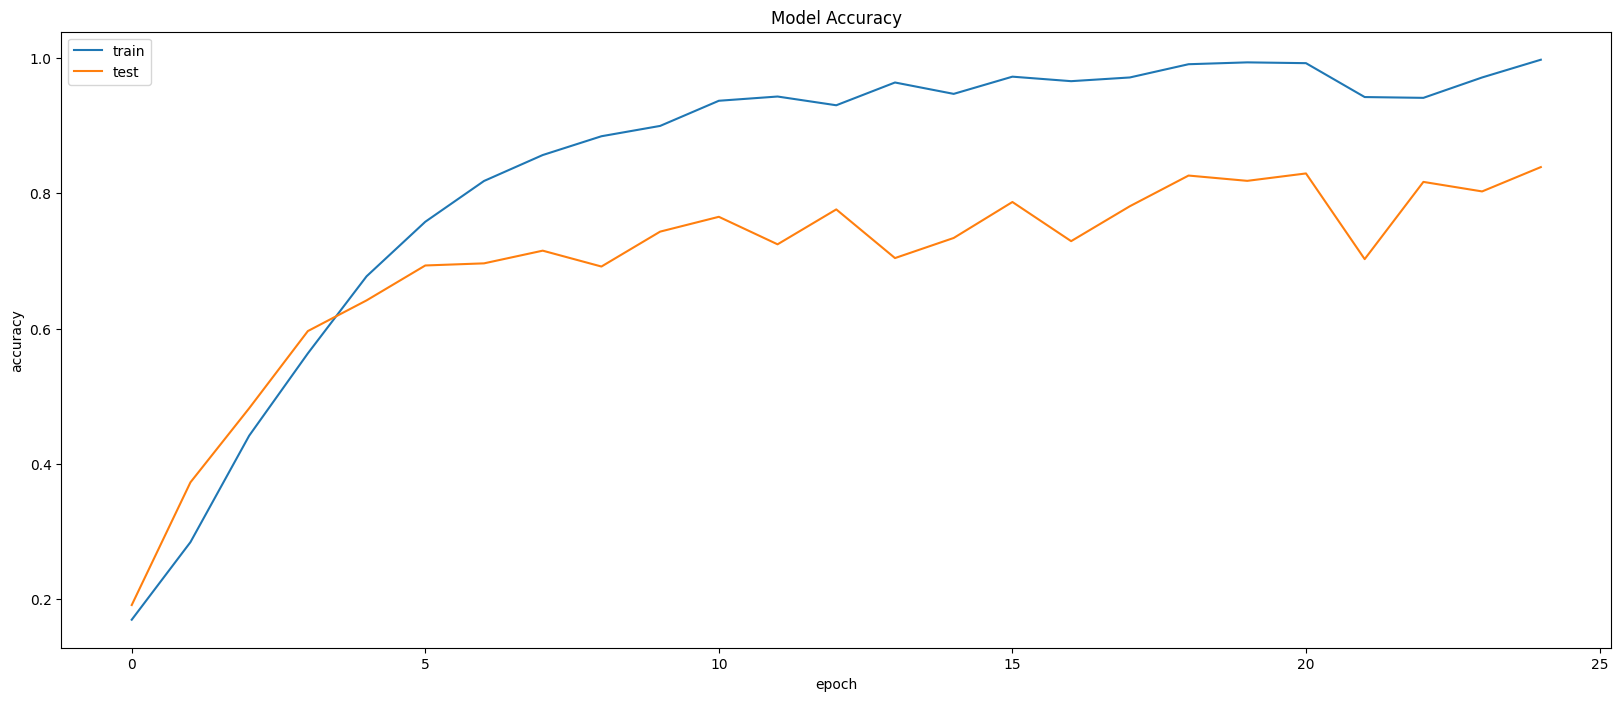

In [58]:
# Accuracy plot
plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

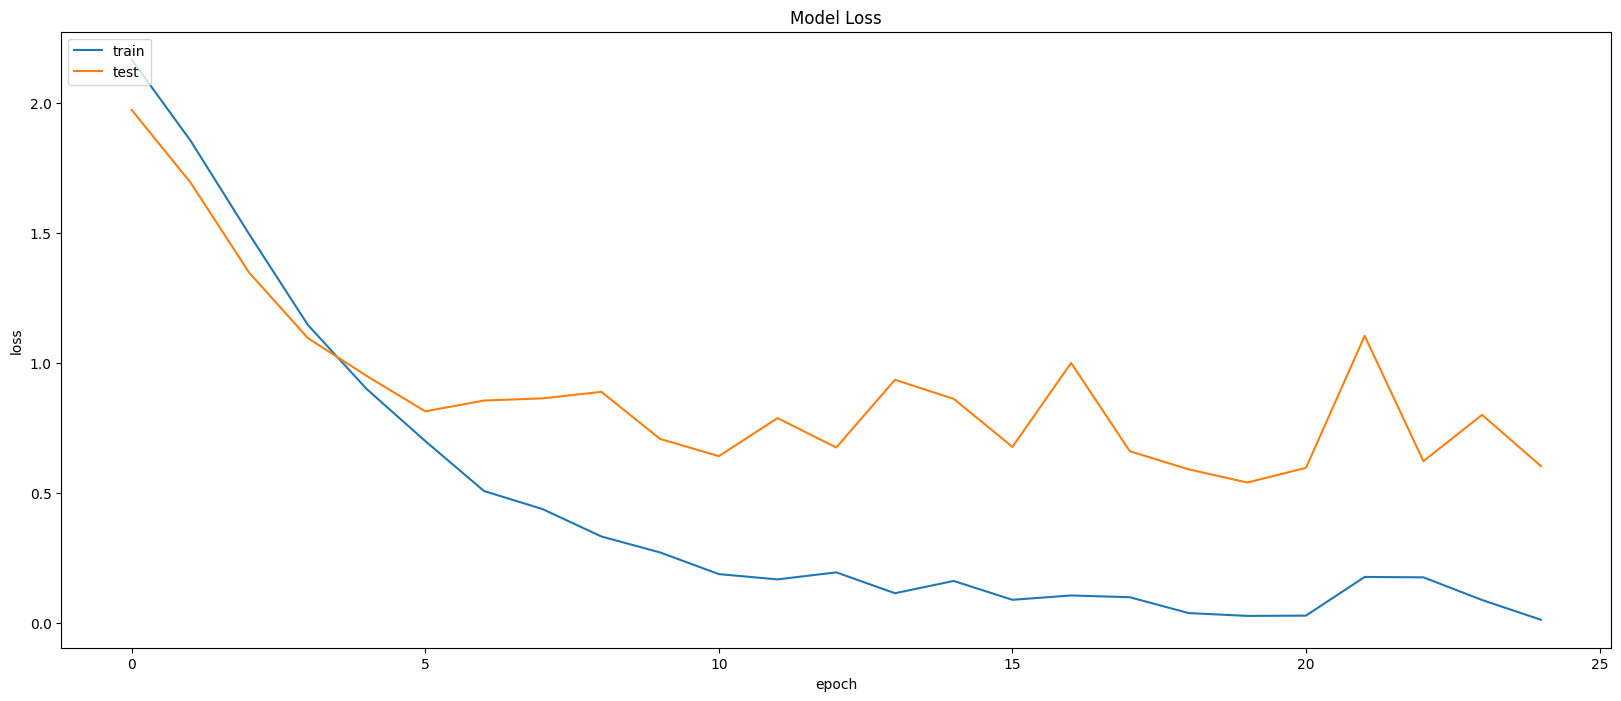

In [59]:
# Loss plot
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Group by Country

In [60]:
# Define constants
DATA_DIR = '/content/drive/MyDrive/5243/Project3/images'

# Function to create a DataFrame with image paths and associated metadata
def create_image_dataframe(data_dir, emotions_df):
    image_data = []
    for _, row in emotions_df.iterrows():
        set_id = row['set_id']
        gender = row['gender']
        age = row['age']
        country = row['country']

        folder_path = os.path.join(data_dir, str(set_id))
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):  # Ensure valid image files
                    image_data.append({
                        'img_path': os.path.join(folder_path, img_file),
                        'set_id': set_id,
                        'gender': gender,
                        'age': age,
                        'country': country
                    })

    return pd.DataFrame(image_data)

# Create the image DataFrame
image_df = create_image_dataframe(DATA_DIR, emotions_df)

# Extract emotion from the image path
def extract_emotion(path):
    filename = os.path.basename(path)
    return filename.replace(os.path.splitext(filename)[1], '')  # Remove the file extension

image_df['emotion'] = image_df['img_path'].apply(extract_emotion)

# Replace countries into two groups: RU and Other
image_df['Country_Group'] = image_df['country'].apply(lambda x: 'RU' if x == 'RU' else 'Other')

# Encode emotion labels
label_encoder = LabelEncoder()
image_df['emotion'] = label_encoder.fit_transform(image_df['emotion'])



In [61]:
# Subset the DataFrame
image_df_subset = image_df[['img_path', 'emotion', 'Country_Group']]

# Split data into train-test sets stratified by Country_Group
train_data, test_data = train_test_split(
    image_df_subset,
    test_size=0.2,
    stratify=image_df_subset['Country_Group'],
    random_state=42
)

# Load and preprocess images
def load_images_and_labels(data_subset):
    X, y = [], []
    for _, row in data_subset.iterrows():
        img = cv2.imread(row['img_path'])
        img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
        X.append(img_resized)
        y.append(row['emotion'])
    return np.array(X), np.array(y)

# Load training and testing data
X_train, y_train = load_images_and_labels(train_data)
X_test, y_test = load_images_and_labels(test_data)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment training data manually
augmented_X, augmented_y = [], []
for i in range(len(X_train)):
    img = X_train[i].reshape((1, *X_train[i].shape))
    label = y_train[i]
    for _ in range(20):  # Generate 20 augmentations per image
        augmented = next(datagen.flow(img, batch_size=1))
        augmented_X.append(augmented[0])
        augmented_y.append(label)

# Convert augmented data to numpy arrays
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

# Combine original and augmented training data
X_train = np.concatenate([X_train, augmented_X], axis=0)
y_train = np.concatenate([y_train, augmented_y], axis=0)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test = to_categorical(y_test, num_classes=len(label_encoder.classes_))

In [62]:
# ResNet model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, mode='max', verbose=1, factor=0.5, min_lr=0.0001)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,770,184 (94.49 MB)

 Trainable params: 1,182,472 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [63]:
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=20,
    callbacks=[early_stopping, lr_reduction]
)

Epoch 1/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 38s 197ms/step - accuracy: 0.1898 - loss: 2.2516 - val_accuracy: 0.0000e+00 - val_loss: 3.2881 - learning_rate: 0.0010
Epoch 2/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.3501 - loss: 1.7004 - val_accuracy: 0.0000e+00 - val_loss: 4.5514 - learning_rate: 0.0010
Epoch 3/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.5308 - loss: 1.2445 - val_accuracy: 0.0000e+00 - val_loss: 5.5852 - learning_rate: 0.0010
Epoch 4/25
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6983 - loss: 0.8048
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.6985 - loss: 0.8045 - val_accuracy: 0.0000e+00 - val_loss: 6.3294 - learning_rate: 0.0010
Epoch 5/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8451 - loss: 0.4675 - val_accuracy: 0.0323 - val_loss: 7.1167 - learning_rate: 5.0000e-04
Epoch 6/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - acc

In [64]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
print("Loss:", loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0323 - loss: 7.1167
Test Accuracy: 0.032258063554763794
Loss: 7.116701602935791


In [65]:
# Add predictions to test_data for Country_Group evaluation
test_data['y_true'] = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
test_data['y_pred'] = np.argmax(y_pred, axis=1)

# Evaluate performance by Country_Group
from sklearn.metrics import classification_report

for group in test_data['Country_Group'].unique():
    group_data = test_data[test_data['Country_Group'] == group]
    y_true = group_data['y_true']
    y_pred = group_data['y_pred']

    # Get unique classes in the subset
    unique_classes = sorted(set(y_true) | set(y_pred))
    target_names = [label_encoder.inverse_transform([cls])[0] for cls in unique_classes]

    print(f"Performance for Country Group: {group}")
    print(classification_report(y_true, y_pred, labels=unique_classes, target_names=target_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Performance for Country Group: RU
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         3
    Contempt       0.00      0.00      0.00         7
     Disgust       0.00      0.00      0.00         3
        Fear       0.00      0.00      0.00         3
       Happy       0.00      0.00      0.00         2
     Neutral       0.00      0.00      0.00         4
         Sad       0.00      0.00      0.00         2
   Surprised       0.50      0.25      0.33         4

    accuracy                           0.04        28
   macro avg       0.06      0.03      0.04        28
weighted avg       0.07      0.04      0.05        28

Performance for Country Group: Other
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00       1.0
    Contempt       0.00      0.00      0.00       1.0
       Happy       0.00      0.00      0.00       0.0
         Sad       0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m